In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw8.ipynb")

# CPSC 330 - Applied Machine Learning

## Homework 8: Introduction to Computer vision and Time Series (Lectures 19 and 20) 

**Due date: see the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).**

## Imports

In [2]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

from sklearn.linear_model import Ridge


<div class="alert alert-info">
    
## Submission instructions
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W1/blob/main/docs/homework_instructions.md). 

**You may work in a group on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).


When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission.
4. Make sure that the plots and output are rendered properly in your submitted file. 
5. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb.

<br><br>

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset and storing it under the `data` folder. We will be forcasting average avocado price for the next week. 

In [3]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.shape

(18249, 13)

In [5]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [6]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [7]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [8]:
assert len(df_train) + len(df_test) == len(df)

<br><br>

<!-- BEGIN QUESTION -->

### 1.1 How many time series? 
rubric={points:4}

In the [Rain in Australia](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) dataset from lecture demo, we had different measurements for each Location. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.1
    
</div>

_Points:_ 4

There are avocado prices for the same day at different **regions**, and for different avocado **types** (conventional or organic). As shown below, the region Albany has 2 avocado prices for each of the same week, and the type 'conventional' has multiple avocado prices for the same week (in multiple different regions).

In [9]:
df_train.sort_values(by=["region", "Date"]).head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
51,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
50,2015-01-11,1.77,1182.56,39.00,305.12,0.00,838.44,838.44,0.00,0.0,organic,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany


In [10]:
df_train.sort_values(by=["type", "Date"]).head(10)

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany
51,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta
51,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.00,conventional,2015,BaltimoreWashington
51,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.00,conventional,2015,Boise
51,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.00,conventional,2015,Boston
51,2015-01-04,1.40,116253.44,3267.97,55693.04,109.55,57182.88,57182.88,0.00,0.00,conventional,2015,BuffaloRochester
51,2015-01-04,0.93,5777334.90,2843648.26,2267755.26,137479.64,528451.74,477193.38,47882.56,3375.80,conventional,2015,California
51,2015-01-04,1.19,166006.29,29419.03,47220.75,38568.95,50797.56,44329.03,6468.53,0.00,conventional,2015,Charlotte
51,2015-01-04,1.11,783068.03,30270.26,550752.19,124506.10,77539.48,72888.46,4651.02,0.00,conventional,2015,Chicago
51,2015-01-04,0.88,228569.58,3274.30,168764.78,1447.06,55083.44,17525.31,37445.46,112.67,conventional,2015,CincinnatiDayton


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.2 Equally spaced measurements? 
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

<div class="alert alert-warning">

Solution_1.2
    
</div>

_Points:_ 4

The measurements in this dataset seem to have 2 weeks for each location (as shown by '0 Days' and '7 Days' for Albany, WestTexNewMexico, and California examples below).
The measurements seem to have 1 week for each type (as shown by the populated '0 Days' for conventional and organic types below).
There do not appear to be any missing values in this dataset and split so there should be no exceptions (as there are no NA values).
The measurements are therefore unevenly spaced between 0 and 7 days for region, and mostly evenly spaced for conventional and organic avocado types.

In [11]:
df_train['region'].isnull().values.any()

False

In [12]:
df_train['type'].isnull().values.any()

False

In [13]:
# Reference code from Lecture 20

In [14]:
def plot_time_spacing_distribution(df, region):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'region' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['region'] == region]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for Albany:
Date
0 days    143
7 days    142
Name: count, dtype: int64



/var/folders/lc/2ck5vysj4t164stxzzchk3100000gn/T/ipykernel_56063/1409762432.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


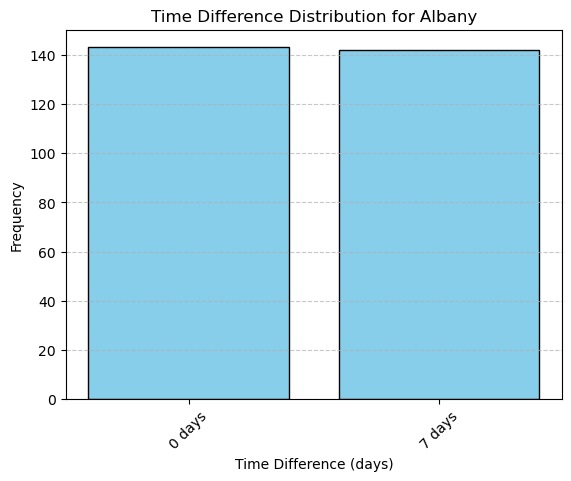

In [15]:
plot_time_spacing_distribution(df_train, 'Albany')

/var/folders/lc/2ck5vysj4t164stxzzchk3100000gn/T/ipykernel_56063/1409762432.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


Time spacing counts for WestTexNewMexico:
Date
0 days    140
7 days    142
Name: count, dtype: int64



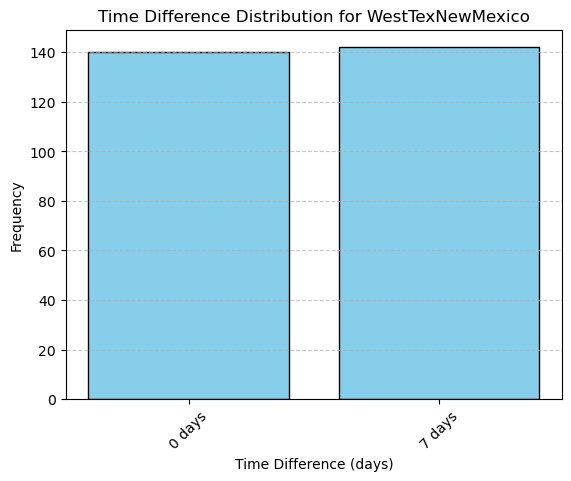

In [16]:
plot_time_spacing_distribution(df_train, 'WestTexNewMexico')

Time spacing counts for California:
Date
0 days    143
7 days    142
Name: count, dtype: int64



/var/folders/lc/2ck5vysj4t164stxzzchk3100000gn/T/ipykernel_56063/1409762432.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


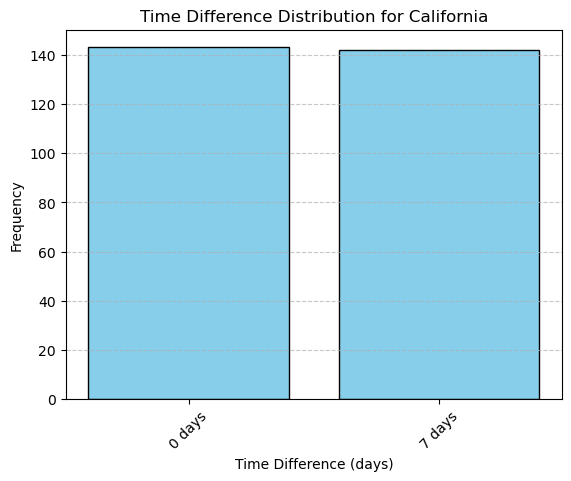

In [17]:
plot_time_spacing_distribution(df_train, 'California')

In [18]:
def plot_time_spacing_distribution_type(df, avocado_type):
    """
    Plots the distribution of time spacing for a given avocado type.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'type' and 'Date'.
        avocado_type (str): The type (e.g., avocado type) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    type_data = df[df['type'] == avocado_type]
    
    if type_data.empty:
        print(f"No data available for type: {avocado_type}")
        return
    
    # Calculate time differences
    time_diffs = type_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {avocado_type}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {avocado_type}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

/var/folders/lc/2ck5vysj4t164stxzzchk3100000gn/T/ipykernel_56063/141508418.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


Time spacing counts for conventional:
Date
0 days    7579
7 days     142
Name: count, dtype: int64



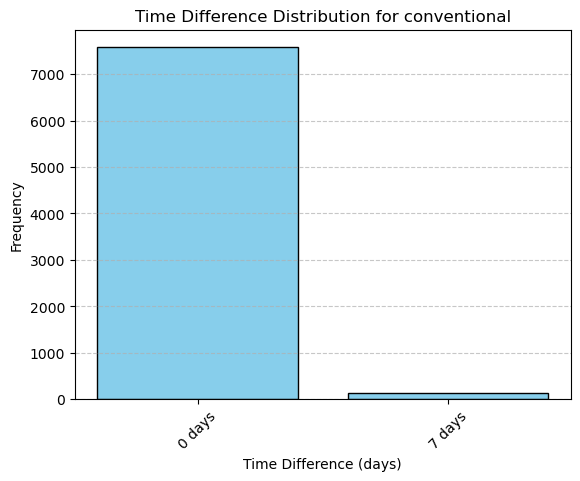

In [19]:
plot_time_spacing_distribution_type(df_train, 'conventional')

/var/folders/lc/2ck5vysj4t164stxzzchk3100000gn/T/ipykernel_56063/141508418.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


Time spacing counts for organic:
Date
0 days    7576
7 days     142
Name: count, dtype: int64



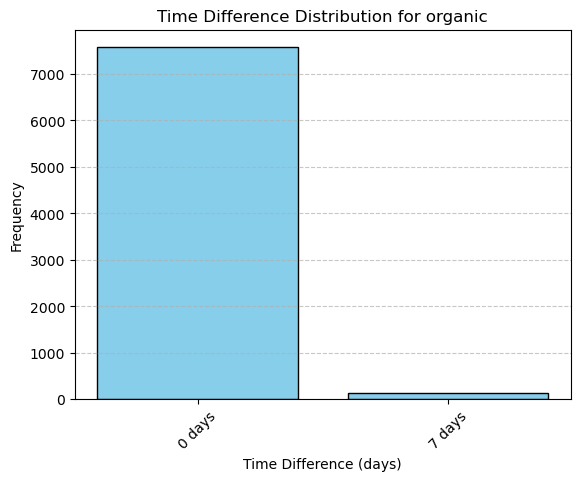

In [20]:
plot_time_spacing_distribution_type(df_train, 'organic')

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.3 Interpreting regions 
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

<div class="alert alert-warning">

Solution_1.3
    
</div>

_Points:_ 4

It appears there may be overlapping regions. For example, there is 'California', but also 'Sacramento', 'LosAngeles', 'SanDiego', 'SanFrancisco' but those cities are all within in California. Also there is 'Southeast', 'TotalUS' and 'Midsouth', etc. which are very general locations and likely overlap with multiple states provided.

In [21]:
df['region'].unique()

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

<!-- END QUESTION -->

<br><br>

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price. The function below is adapted from [Lecture 19](https://github.com/UBC-CS/cpsc330-2023W1/tree/main/lectures), with some improvements.

In [22]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [23]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [24]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


Our goal is to predict `AveragePriceNextWeek`. 

Let's split the data:

In [25]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

<br><br>

<!-- BEGIN QUESTION -->

### 1.4 `AveragePrice` baseline 
rubric={points}

Soon we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML though, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get on the train and test data?

<div class="alert alert-warning">

Solution_1.4
    
</div>

_Points:_ 4

I got an R^2 score of 0.83 on the training data, and 0.76 on the test data.

In [26]:
train_r2 = r2_score(df_train['AveragePriceNextWeek'], df_train['AveragePrice'])
train_r2

0.8285800937261841

In [27]:
test_r2 = r2_score(df_test['AveragePriceNextWeek'], df_test['AveragePrice'])
test_r2

0.7631780188583048

In [28]:
assert not train_r2 is None, "Are you using the correct variable name?"
assert not test_r2 is None, "Are you using the correct variable name?"
assert sha1(str(round(train_r2, 3)).encode('utf8')).hexdigest() == 'b1136fe2a8918904393ab6f40bfb3f38eac5fc39', "Your training score is not correct. Are you using the right features?"
assert sha1(str(round(test_r2, 3)).encode('utf8')).hexdigest() == 'cc24d9a9b567b491a56b42f7adc582f2eefa5907', "Your test score is not correct. Are you using the right features?"

In [29]:
# model score dataframe
scores = {'Encoding': ['AveragePrice Baseline'],
        'Train R^2 Score': [train_r2],
'Test R^2 Score': [test_r2]}

scores_df = pd.DataFrame(scores)
scores_df.set_index('Encoding', inplace=True)
scores_df

,Train R^2 Score,Test R^2 Score
Encoding,,
AveragePrice Baseline,0.82858,0.763178


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 1.5 Forecasting average avocado price
rubric={points:10}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<div class="alert alert-warning">

Solution_1.5
    
</div>

_Points:_ 10

In [30]:
print(df_train.isnull().sum())
print(df_test.isnull().sum())

# No NA values, but will include imputation in the model in case NA values are
# encountered during deployment

Date                    0
AveragePrice            0
Total Volume            0
4046                    0
4225                    0
4770                    0
Total Bags              0
Small Bags              0
Large Bags              0
XLarge Bags             0
type                    0
year                    0
region                  0
AveragePriceNextWeek    0
dtype: int64
Date                    0
AveragePrice            0
Total Volume            0
4046                    0
4225                    0
4770                    0
Total Bags              0
Small Bags              0
Large Bags              0
XLarge Bags             0
type                    0
year                    0
region                  0
AveragePriceNextWeek    0
dtype: int64


In [31]:
df_train.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'AveragePriceNextWeek'],
      dtype='object')

In [32]:
numeric_features = ['AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'year']
categorical_features = ['type', 'region']
drop_features = ['Date']
target = ['AveragePriceNextWeek']

# Referenced Lecture 20

def preprocess_features(
    df_train,
    df_test,
    numeric_features,
    categorical_features,
    drop_features,
    target
):

    all_features = set(numeric_features + categorical_features + drop_features + target)
    if set(df_train.columns) != all_features:
        print("Missing columns", set(df_train.columns) - all_features)
        print("Extra columns", all_features - set(df_train.columns))
        raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    preprocessor = make_column_transformer(
        (numeric_transformer, numeric_features),
        (categorical_transformer, categorical_features),
        ("drop", drop_features),
    )
    preprocessor.fit(df_train)
    ohe_feature_names = (
        preprocessor.named_transformers_["pipeline-2"]
        .named_steps["onehotencoder"]
        .get_feature_names_out(categorical_features)
        .tolist()
    )
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(
        preprocessor.transform(df_train), index=df_train.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
        preprocessor.transform(df_test), index=df_test.index, columns=new_columns
    )

    y_train = df_train["AveragePriceNextWeek"]
    y_test = df_test["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [33]:
# Referenced Lecture 20


def score_lr_print_coeff(preprocessor, df_train, y_train, df_test, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, Ridge())
    lr_pipe.fit(df_train, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(df_train, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(df_test, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["ridge"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [34]:
# encoding date method #1: Days Since January 4th, 2015 (for non-linear models_
# Referenced Lecture 20


first_day = df_train["Date"].min()

df_train_days = df_train.assign(
    Days_since=df_train["Date"].apply(lambda x: (x - first_day).days)
)
df_test_days = df_test.assign(
    Days_since=df_test["Date"].apply(lambda x: (x - first_day).days)
)

df_train_days.sort_values(by="Date").head()


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek,Days_since
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24,0
13858,2015-01-04,0.94,461607.33,244152.26,165299.33,15302.75,36852.99,30884.29,5595.00,373.7,conventional,2015,SanDiego,0.82,0
1352,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston,1.10,0
13689,2015-01-04,1.33,9213.49,3727.52,4327.52,0.00,1158.45,1158.45,0.00,0.0,organic,2015,Sacramento,1.27,0
13520,2015-01-04,1.05,430138.88,110693.69,270107.61,9737.50,39600.08,39600.08,0.00,0.0,conventional,2015,Sacramento,1.09,0


In [35]:
X_train_enc_days, y_train_days, X_test_enc_days, y_test_days, preprocessor_days = preprocess_features(
    df_train_days,
    df_test_days,
    numeric_features + ["Days_since"],
    categorical_features,
    drop_features,
    target
)

scores_df.loc['Numerical Time'] = [0.85, 0.78]
display(scores_df)
score_lr_print_coeff(preprocessor_days, df_train_days, y_train_days, df_test_days, y_test_days, X_train_enc_days)

,Train R^2 Score,Test R^2 Score
Encoding,,
AveragePrice Baseline,0.82858,0.763178
Numerical Time,0.85000,0.780000


Train score: 0.85
Test score: 0.78


,Coef
AveragePrice,0.324498
region_SanFrancisco,0.091838
region_HartfordSpringfield,0.089592
region_NewYork,0.070944
region_Philadelphia,0.052258
...,...
region_Denver,-0.047782
type_conventional,-0.052177
region_DallasFtWorth,-0.069429
region_SouthCentral,-0.070072


**Justification**:
I chose to try encoding the date as the 'days since' the first day (January 4, 2015) since I wanted to first see how a numerical feature would perform. However this was just to test out numerical encoding, as I know linear models do ont always work best with cyclic patterns in numerically-encoded features.

In [36]:
# encoding date method #2: OHE month (for linear models)
# Referenced Lecture 20

df_train_month = df_train.assign(
    Month=df_train["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
df_test_month = df_test.assign(Month=df_test["Date"].apply(lambda x: x.month_name()))

df_train_month[["Date", "Month"]].sort_values(by="Month")

,Date,Month
1304,2017-04-30,April
9869,2016-04-17,April
9025,2016-04-24,April
3332,2017-04-30,April
3331,2017-04-23,April
...,...,...
11241,2016-09-04,September
11242,2016-09-11,September
11243,2016-09-18,September
11293,2017-09-03,September


In [37]:
X_train_enc_month, y_train_month, X_test_enc_month, y_test_month, preprocessor_month = preprocess_features(
    df_train_month,
    df_test_month,
    numeric_features,
    categorical_features + ['Month'],
    drop_features,
    target
)

scores_df.loc['OHE Month'] = [0.85, 0.80]
display(scores_df)
score_lr_print_coeff(preprocessor_month, df_train_month, y_train_month, df_test_month, y_test_month, X_train_enc_month)


,Train R^2 Score,Test R^2 Score
Encoding,,
AveragePrice Baseline,0.82858,0.763178
Numerical Time,0.85000,0.780000
OHE Month,0.85000,0.800000


Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.316203
region_SanFrancisco,0.100836
region_HartfordSpringfield,0.098581
region_NewYork,0.077590
region_Philadelphia,0.057388
...,...
region_Denver,-0.052920
type_conventional,-0.057247
region_SouthCentral,-0.074909
region_DallasFtWorth,-0.075811


**Justification**:
I chose to encode the date as a OneHot encoding of the month, since linear models work better with categorical features that they can capture patterns from better. 

In [38]:
# encoding date method #3: OHE seasons (for linear models)
# Referenced Lecture 20

def get_season(month):
    WINTER_MONTHS = ["December", "January", "February"] 
    AUTUMN_MONTHS = ["September", "October", "November"]
    SUMMER_MONTHS = ["June", "July", "August"]
    SPRING_MONTHS = ["March", "April", "May"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

df_train_season = df_train_month.assign(Season=df_train_month["Month"].apply(get_season))
df_test_season = df_test_month.assign(Season=df_test_month["Month"].apply(get_season))

In [39]:
X_train_enc_season, y_train_season, X_test_enc_season, y_test_season, preprocessor_season = preprocess_features(
    df_train_season,
    df_test_season,
    numeric_features,
    categorical_features + ["Season"],
    drop_features + ["Month"],
    target
)

scores_df.loc['OHE Season'] = [0.85, 0.79]
display(scores_df)
coeff_df = score_lr_print_coeff(
    preprocessor_season, df_train_season, y_train_season, df_test_season, y_test_season, X_train_enc_season
)

,Train R^2 Score,Test R^2 Score
Encoding,,
AveragePrice Baseline,0.82858,0.763178
Numerical Time,0.85000,0.780000
OHE Month,0.85000,0.800000
OHE Season,0.85000,0.790000


Train score: 0.85
Test score: 0.79


**Justification**:
I chose to encode the date as the season using the previously encoded month encodings. This was to test out another categorical feature for linear regression to see if it would improve the scores compared to the baseline.

Approach that worked the best: OneHot Encoding the months seemed to give the highest test score. Although all scores were relatively similar, with the same training scores.

In [40]:
scores_df.loc['OHE Month']

Train R^2 Score    0.85
Test R^2 Score     0.80
Name: OHE Month, dtype: float64

**Discussion of Results:**
All date encodings (numerical and categorical) seem to be performing better than the baseline, which is a good sign. There seems to be a bit of overfitting, as the train scores are higher than the test scores (by around a magnitude of 0.5 to 0.7), although it is not a drastic difference. And considering the train and test scores are both relatively high, these encodings seem to be helpful for making predictions with a linear regression model on avocado prices. The best encoding seems to be the OneHot encoding of the date as months - which gave a test score of 0.80 and a train score of 0.85.

<!-- END QUESTION -->

<br><br><br><br>

## Exercise 2: Short answer questions

<!-- BEGIN QUESTION -->

### 2.1 Time series

rubric={points:6}

The following questions pertain to Lecture 20 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.
3. When studying time series modeling, we explored several ways to encode date information as a feature for the citibike dataset. When we used time of day as a numeric feature, the Ridge model was not able to capture the periodic pattern. Why? How did we tackle this problem? Briefly explain.

<div class="alert alert-warning">

Solution_2.1
    
</div>

_Points:_ 6

1. An example of where a time series data would have unequally spaced time points would be (an individual's) thermometer measurements as it would be unlikely to get a measurement for each day. Rather, it is more likely that measurements would take place arbitrarily throughout whichever time period is being considered when an individual is feeling sick and feels the need to check their temperature.
2. Lagged versions of features would struggle with unequally spaced time points since the lagged feature relies on the subsequent feature. Encoding the date as a feature such as a month or season would still work as they are independent encodings and do not rely on their "neighboring" measurements.
3. Because linear models struggle with numerical features for identifying cyclic patterns, Ridge was unable to capture the periodic pattern because linear functions with linear features learn linear relationships. Linear models can capture patterns with categorical features, so we tackled this problem by encoding the time of day as a categorical feature (one hot encoding).

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

### 2.2 Computer vision 
rubric={points:6}

The following questions pertain to Lecture 19 on multiclass classification and introduction to computer vision. 

1. How many parameters (coefficients and intercepts) will `sklearn`’s `LogisticRegression()` model learn for a four-class classification problem, assuming that you have 10 features? Briefly explain your answer.
2. In Lecture 19, we briefly discussed how neural networks are sort of like `sklearn`'s pipelines, in the sense that they involve multiple sequential transformations of the data, finally resulting in the prediction. Why was this property useful when it came to transfer learning?
3. Imagine that you have a small dataset with ~1000 images containing pictures and names of 50 different Computer Science faculty members from UBC. Your goal is to develop a reasonably accurate multi-class classification model for this task. Describe which model/technique you would use and briefly justify your choice in one to three sentences.

<div class="alert alert-warning">

Solution_2.2
    
</div>

_Points:_ 6

1. LogisticRegression() would learn 40 parameters because it learns one coefficient per feature per class. Since there are 4 classes, there are 40 (4 x 10) features it will learn from, therefore resulting in 40 coefficients.
2. It is useful for neural networks to involve sequential transformations when making a prediction for transfer learning because you can tune your models at any stage of the transformations (usually from the very last transformation where you can extract the final feature vectors). This allows you to use the model as-is until the point where it returns the actual prediction. By doing this, you can extract feature vectors from this model and use them to train a new model, while reducing the need to train your model on a large training set.
3. I would use transfer learning since the dataset provided is small. I would use a pre-trained (if available) logistic regression model as it is simple (and we only need it to be "reasonably accurate), computationally inexpensive, and interpretable. It would provide useful coefficients for interpreting the features associated with each Computer Science faculty member.

<!-- END QUESTION -->

<br><br>

**Before submitting your assignment, please make sure you have followed all the instructions in the Submission instructions section at the top.** 

![](img/eva-well-done.png)